# AC: Interest and sales of AC dependent on temperature


### 0. Imports and data visualization

In [9]:
import matplotlib.pyplot as plt
import hypotesis.learning as ln
import pandas as pd
import hypotesis.enrichment.weather_analyze as wa
import hypotesis.enrichment.activity_analyze as aa

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)

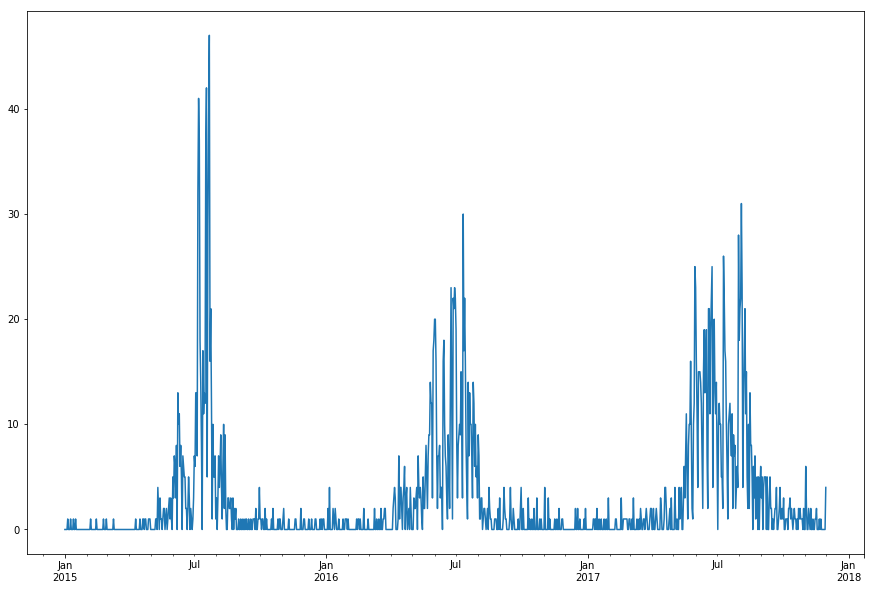

In [6]:
ac_sellout = ln._get_activity_data('bigbang', 'sellout', 'klima')['quantity']
ac_sellout.plot()
plt.show()

Above plot shows daily BigBang AC sellout for period from 1.1.2015 to 30.11.2017

### 1. Defining correlation between search and sales

***Hypotesis***: There is a correlation between **search** on Ceneje.si and **sellout** of Bigbang 

**Variables**: 
    * Daily BIGBANG sellout data
    * Daily Ceneje pageviews for AC Category
    * Daily Ceneje clicks for AC category
    * Daily Ceneje redirects to BIGBANG

Plot activity on Ceneje (pageviews and clicks) for AC category for period from 1.1.2015 to 30.11.2017

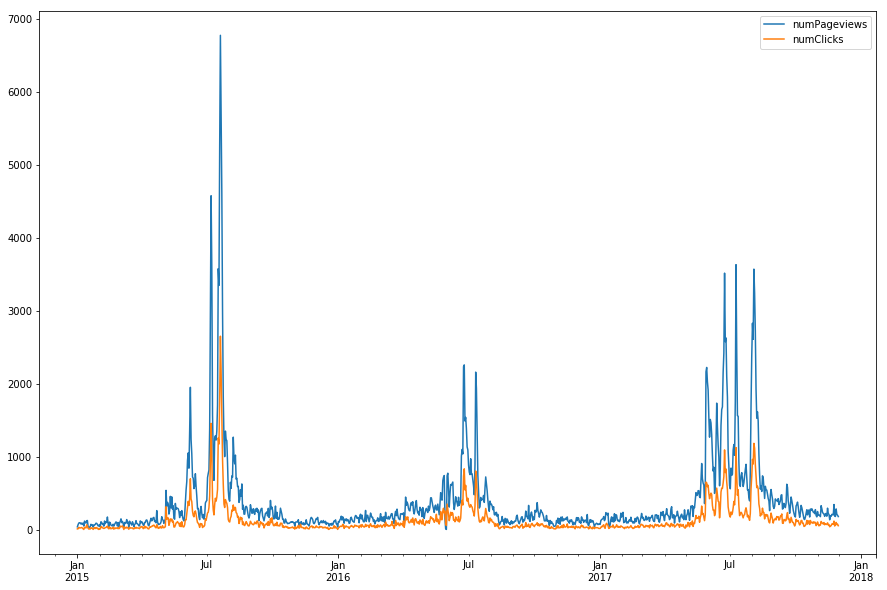

In [41]:
ceneje_activity = ln._get_activity_data('ceneje', 'views', 'klima')

We would like to find if there is any kind of correlation between pageviews on Ceneje.si and sales of BigBang for AC category. Ideally we would like to predict upcoming peaks of BigBang sales based on current changes of pageviews at Ceneje.si. 

The simplest step is to check if there is any correlation between pageviews and sales both from the same, **"current day"**. Of course this is not forecasting but it can give us some intuition whether pageviews and sales are directly related.

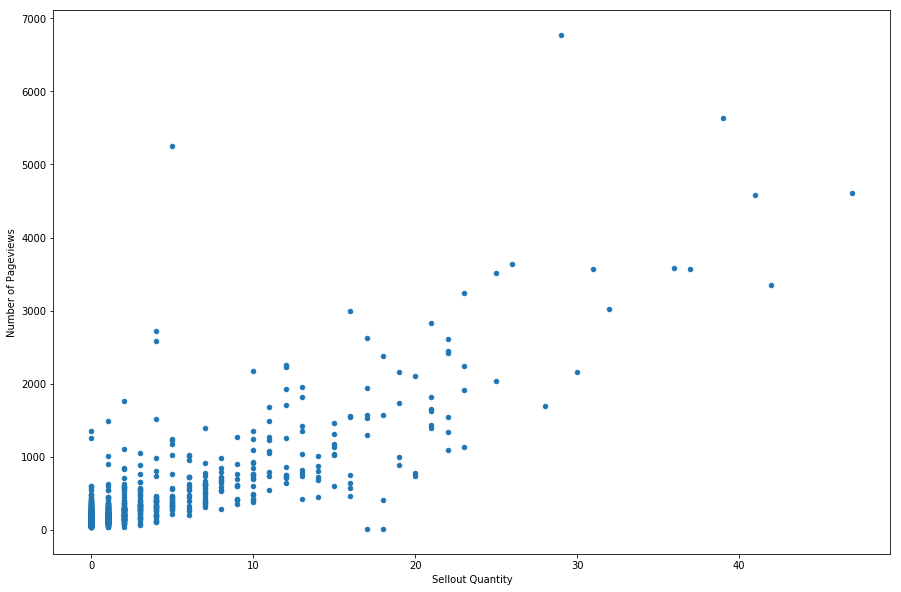

In [50]:
pageviews = ceneje_activity.numPageviews
pd.DataFrame({'Number of Pageviews': pageviews, 'Sellout Quantity': ac_sellout}).plot(y='Number of Pageviews', x='Sellout Quantity', kind='scatter')
plt.show()

Plot shows the dependency of **sellout** variable on **pageviews** variable. We can observe that pageviews higher then **2000** suggest a presence of peak (sellout above 10 ACs) as this is true for all but 3 examples.
Moreover pageview threshold of ***1500*** covers most of the peaks for year 2017 (with 4 false positives).

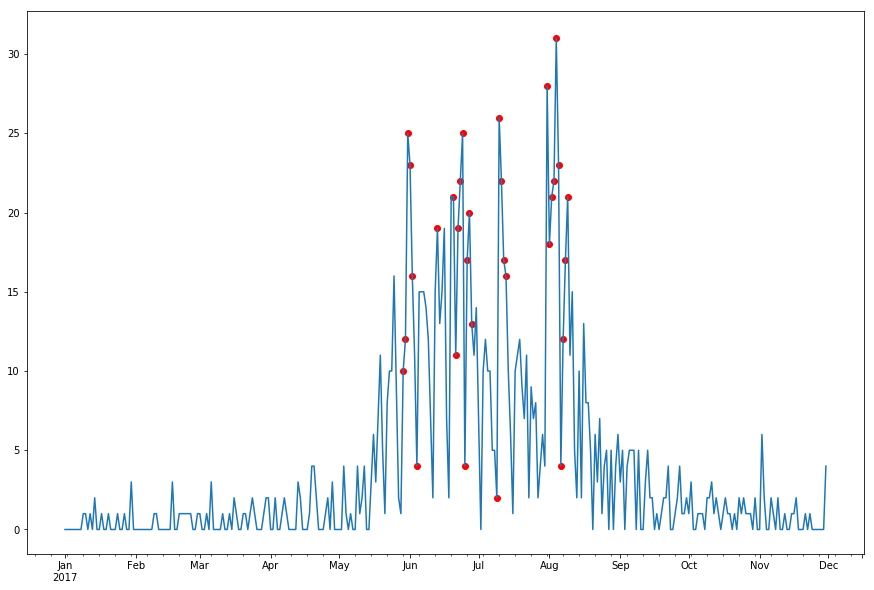

In [45]:
mask_2017 = ac_sellout.index.year == 2017
sellout_2017 = ac_sellout[mask_2017]
pageviews_2017 = pageviews[mask_2017]

sellout_2017.plot()
plt.scatter(sellout_2017[pageviews_2017 >= 1500].index, sellout_2017[pageviews_2017 >= 1500], color='red')
plt.show()


Forecasting 0 days in the future (nowcasting) is not an useful thing to do in our case but it gives us at least some simple intuition that some dependencies might exist.

Let's go a step further and build a model that will rely solely on pageviews from Ceneje and will try to predict the peak in BigBang sales happening exactly on **n-th day** in the future. Keep in mind the tradeoff between precision and recall of the model which can be tuned by setting the threshold higher of lower. **High threshold** usually suggest higher precision which means lower rate of **false positive examples** but causes a larger number of **false negative examples** - model makes only confident predictions and consequently skips a few peaks. **Lower threshold** usually comes with a higher recall which introduces lower number of **false negative examples** for a cost of increased number of **false positive examples**. Classifier can be tuned depending on our needs.

We have collected the current results of our peak prediction model which relies solely on pageviews together with the precision-recall curve for each **n** from 1 to 10.

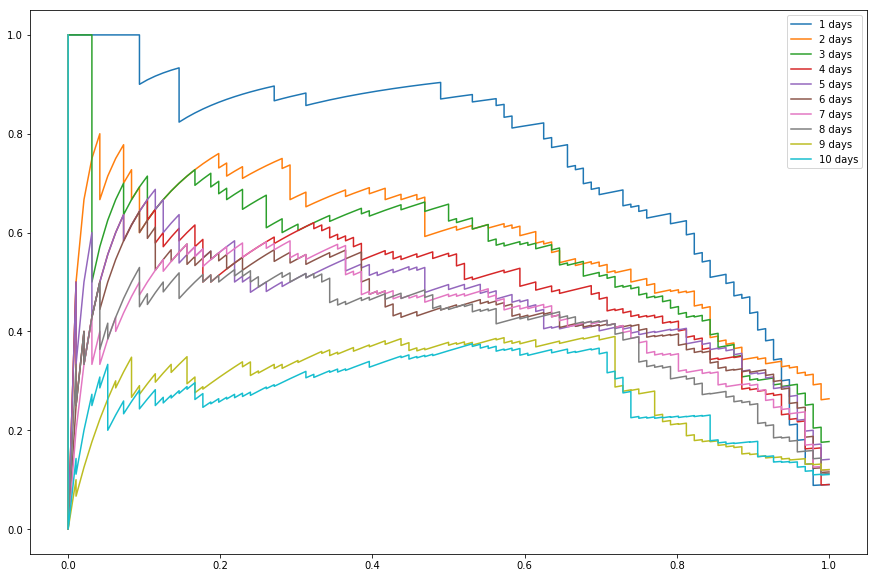

In [46]:
aa.predict_with_model(pageviews, ac_sellout)

**X axis** measures **recall** while **Y axis** measures **precision**. Each point **(x,y)** on the curve corresponds to some specific threshold which yields **precision=y** and **recall=x**. 

We can build the same kind of model for number of clicks on Ceneje.

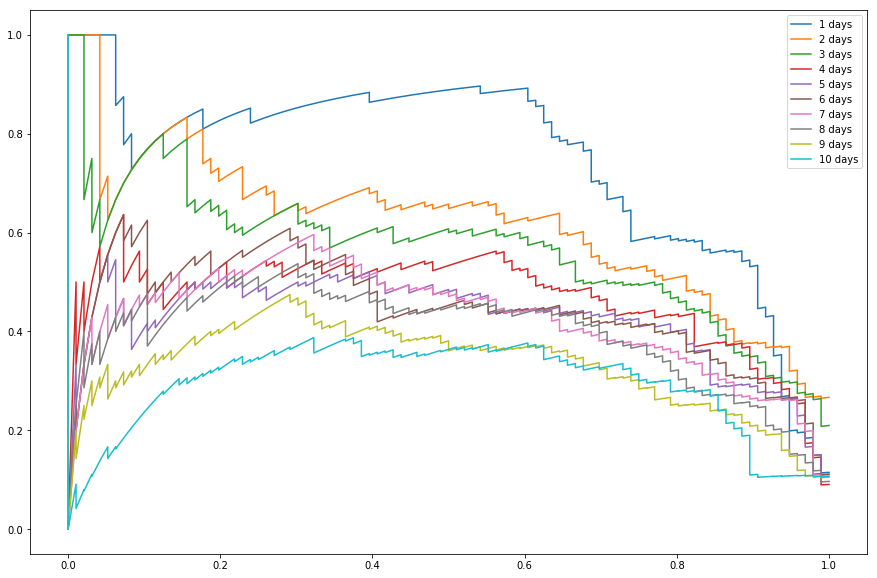

In [47]:
clicks = ceneje_activity.numClicks
aa.predict_with_model([clicks], ac_sellout)

**X axis - RECALL, Y axis - PRECISION**

Or a joint model using both pageviews and clicks

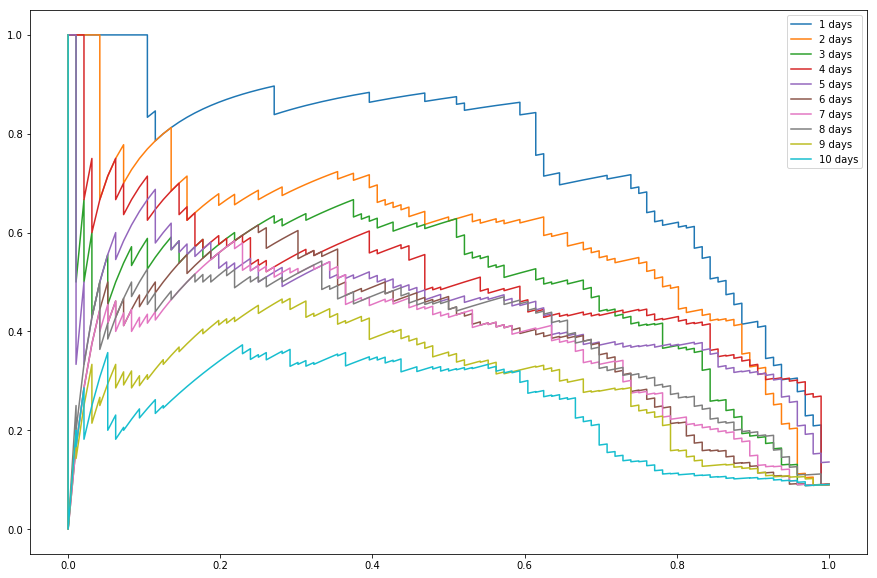

In [48]:
aa.predict_with_model([pageviews, clicks], ac_sellout)

**X axis - RECALL, Y axis - PRECISION**

The last plot is precision-recall curve of combined models (pageviews + clicks). With the ***1 days*** model we can forecast a presence of the peak for **tomorrow** with precision of **80%** and recall of **60%** if we set the threshold right. If the model predicts a peak for tomorrow there is **80%** chance the model is right.

## 2. Defining correlation between weather and sales

***Hypotesis***: AC sales is dependent on peaks of high temperature

**Variables**: 
    * Daily BIGBANG sellout data
    * Surface temperature 

In [2]:
import sqlite3

# load temperature
conn = sqlite3.connect('weather.db') 
wf = pd.read_sql('''
    select * 
    from weather 
    where shortName="2t" and region=10 and dayOffset=0 
    and fromHour=6 and toHour=18 and aggFunc="max"''', conn) 

wf['validDate'] = pd.to_datetime(wf['validDate'])
wf.set_index('validDate', drop=False, inplace=True)

Is there any kind of correlation between sales on the current day and maximum temperature?

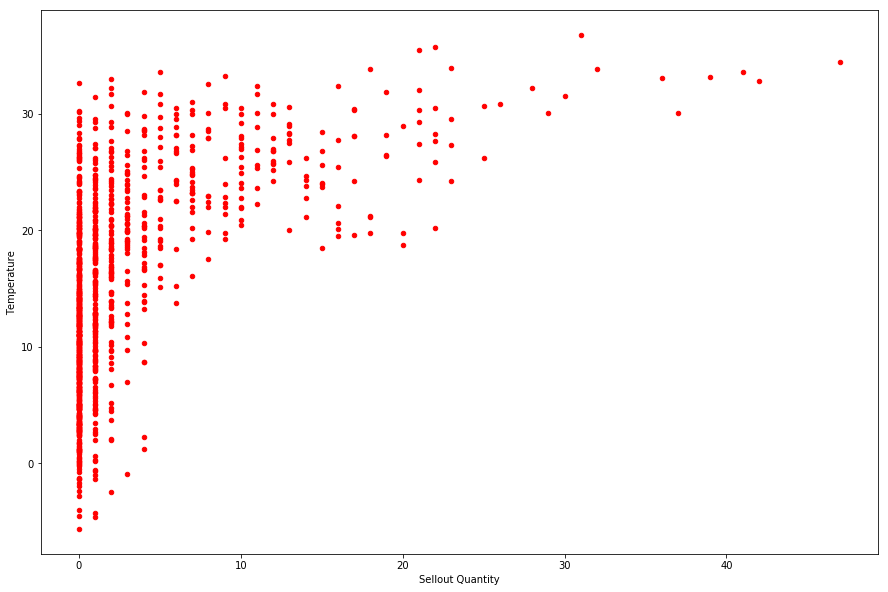

In [58]:
pd.DataFrame({'Temperature': wf['value'] - 273.15, 'Sellout Quantity': ac_sellout}).plot(y='Temperature', x='Sellout Quantity', kind='scatter', color='red')
plt.show()

As we can observe there is no clear threshold above which all the sellout quantities are peaks (actually there is above 33.5°C but we have a really small number of supporting examples).

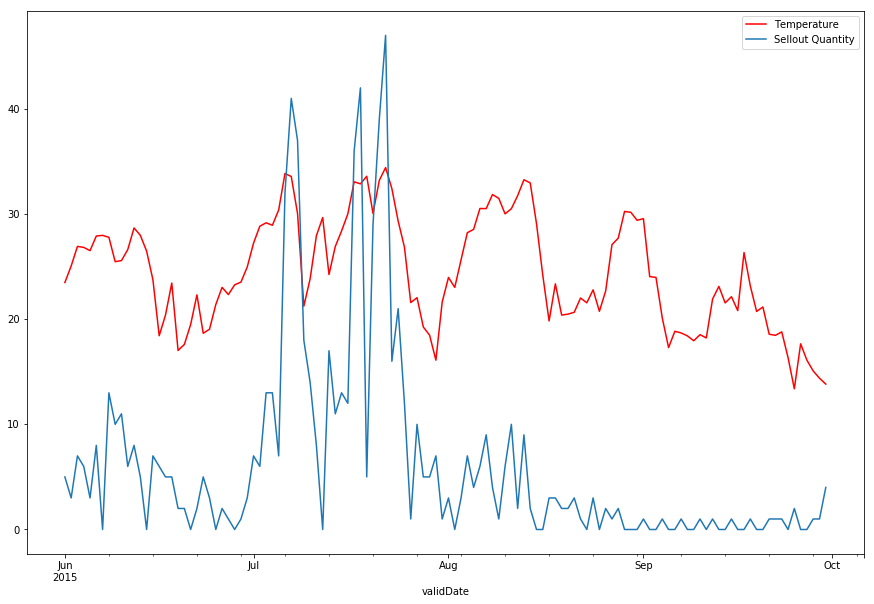

In [63]:
# plot year 2015
mask = (wf.index.year == 2015) & (wf.index.month >= 6) & (wf.index.month <= 9)
(wf[mask]['value'] - 273.15).plot(label='Temperature', color='red')
ac_sellout[mask].plot(label='Sellout Quantity').plot()
plt.legend()
plt.show()

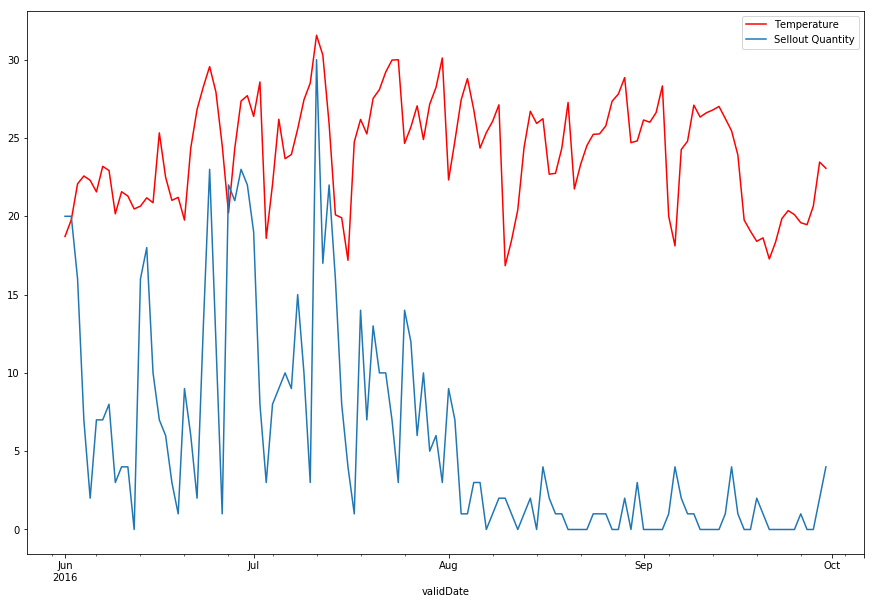

In [64]:
# plot year 2016
mask = (wf.index.year == 2016) & (wf.index.month >= 6) & (wf.index.month <= 9)
(wf[mask]['value'] - 273.15).plot(label='Temperature', color='red')
ac_sellout[mask].plot(label='Sellout Quantity').plot()
plt.legend()
plt.show()

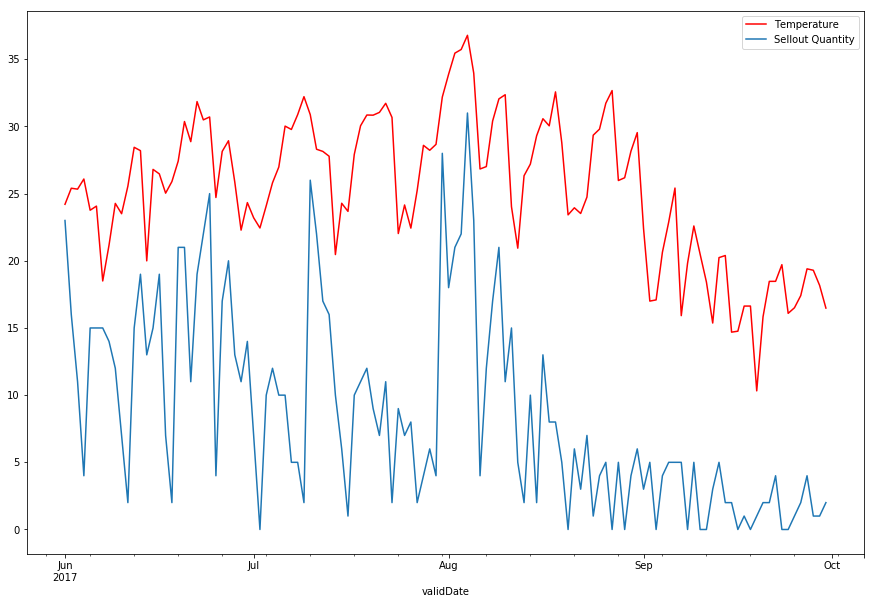

In [65]:
# plot year 2017
mask = (wf.index.year == 2017) & (wf.index.month >= 6) & (wf.index.month <= 9)
(wf[mask]['value'] - 273.15).plot(label='Temperature', color='red')
ac_sellout[mask].plot(label='Sellout Quantity').plot()
plt.legend()
plt.show()

Treating each day as a unit of its own is a bad idea since it looks like peak forecast from temperature heavily depends on the context - what has happened in not so near past. This is currently a work in progress. 

Nevertheless we have a peak forecasting model that besides temperature takes into account total percipitation and sun duration. sun duration.

In [3]:
# load extended set of parameters
wf = pd.read_sql('''
    select * 
    from weather 
    where shortName="2t" or shortName="tp" or shortName="sund"''', conn) 

wf['validDate'] = pd.to_datetime(wf['validDate'])
wf.set_index('validDate', drop=False, inplace=True)

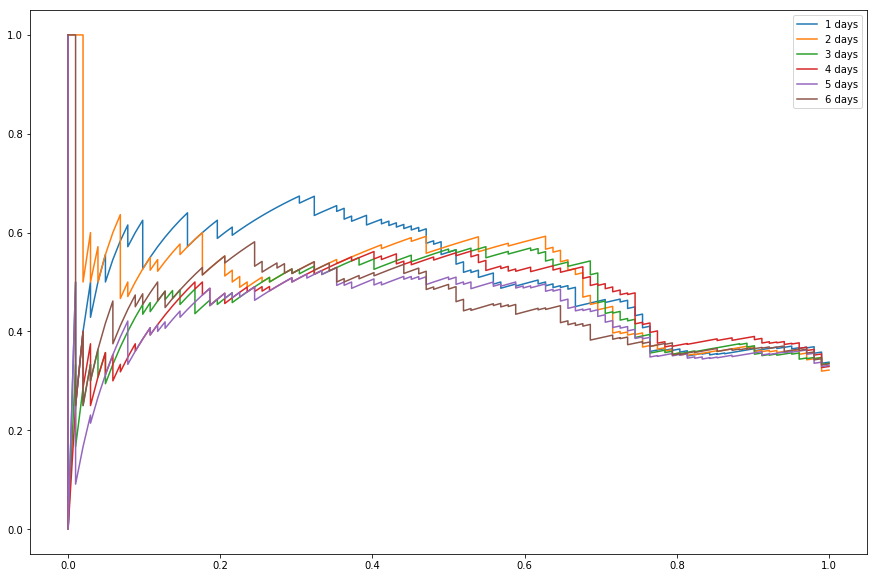

In [73]:
# use only seasonal data
mask = (ac_sellout.index.month >= 6) & (ac_sellout.index.month <= 9)

# train the model
wa.predict_with_model(wf, ac_sellout[mask], mask=mask)

**X axis - RECALL, Y axis - PRECISION**

Precision-recall picture of peak forecasting from weather parameters.

Ok but this are just numbers, how to see what is going on in practice?

Clearly not all of the peaks are influenced by the weather. But lets say at least **30%** of all peaks is.
We will set the bottom recall to 0.3 and display the results for the best precision model can obtain.

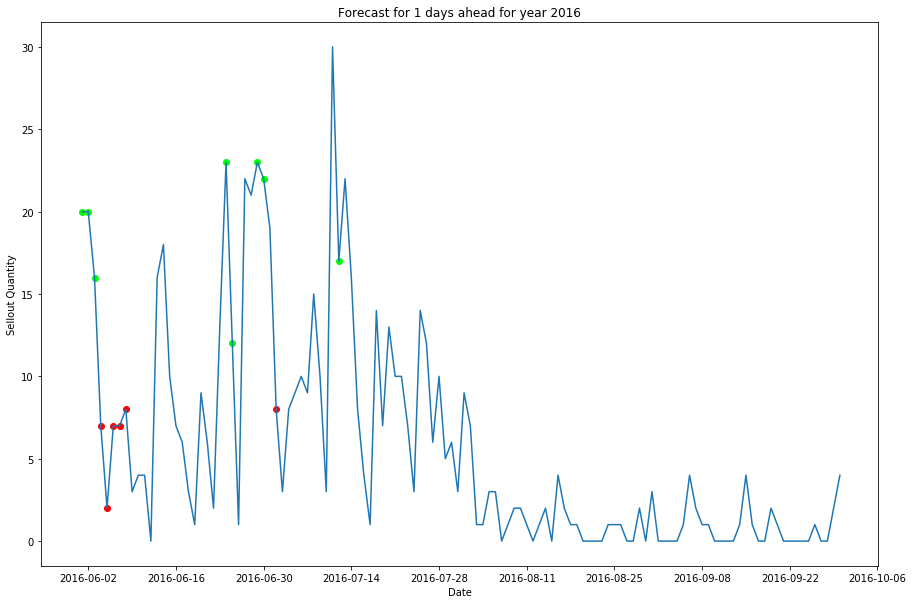

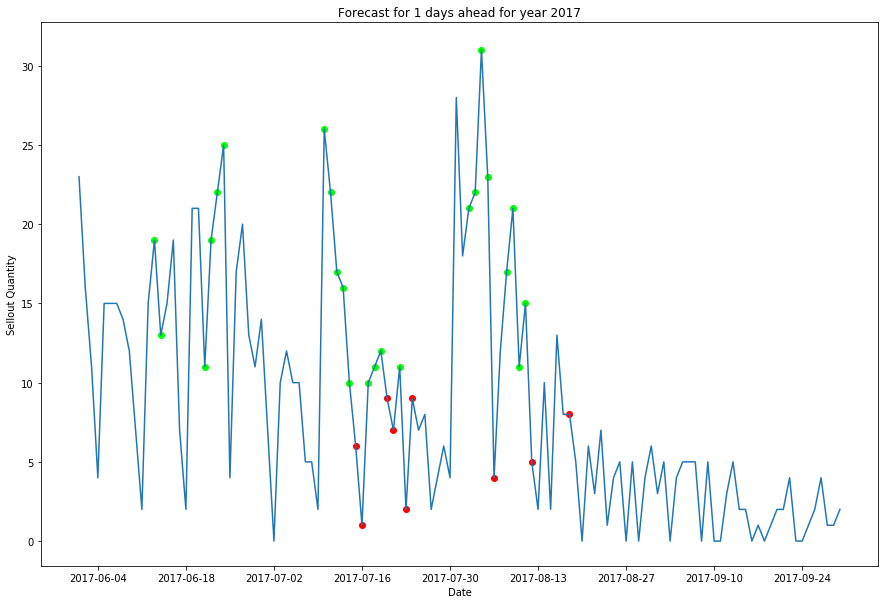

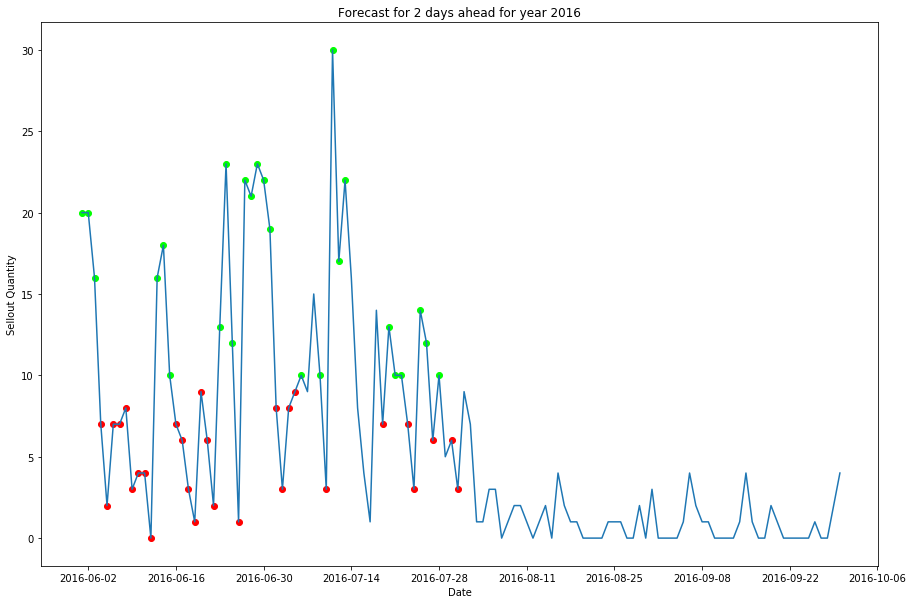

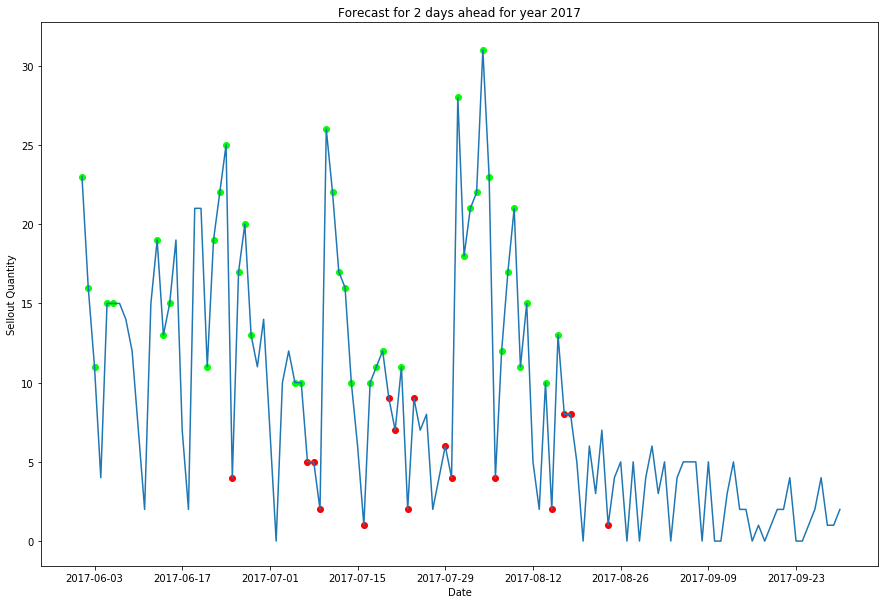

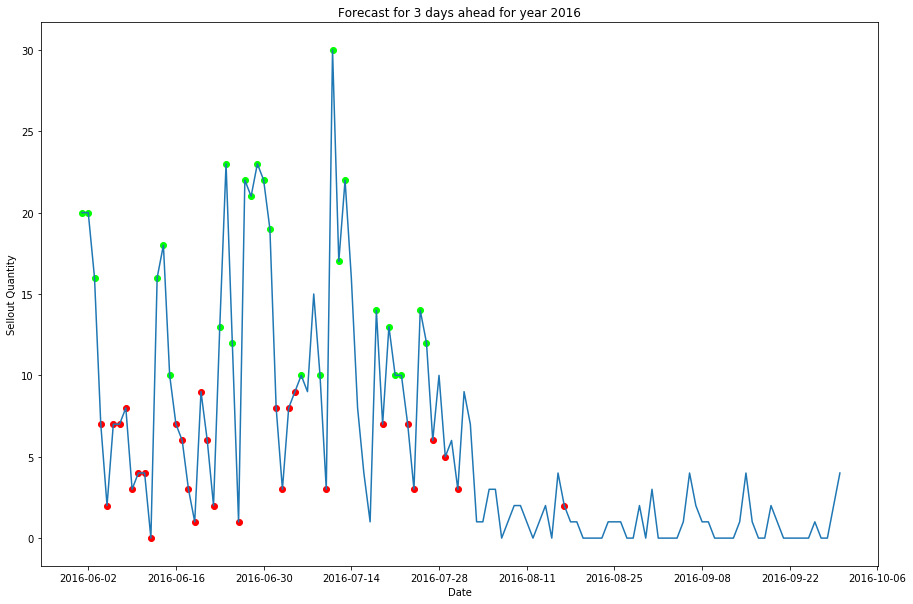

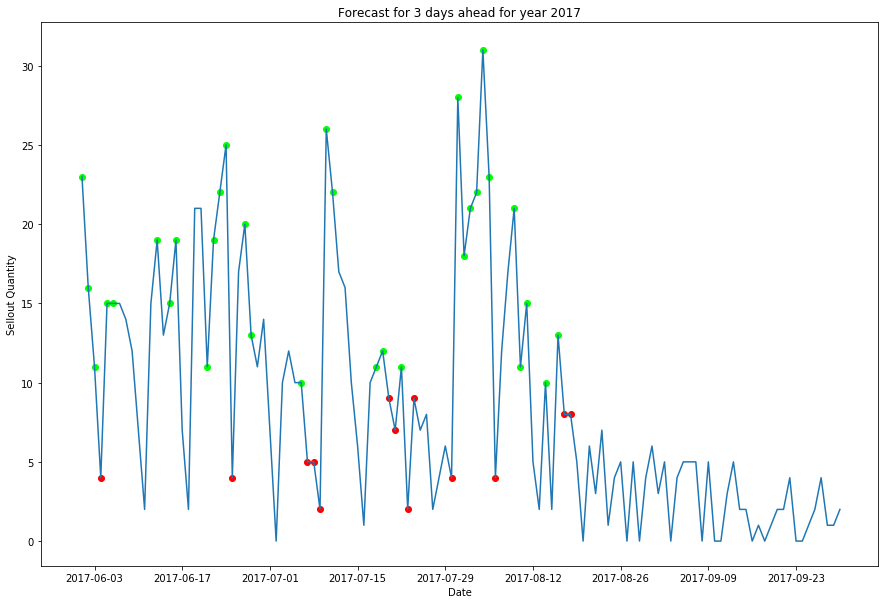

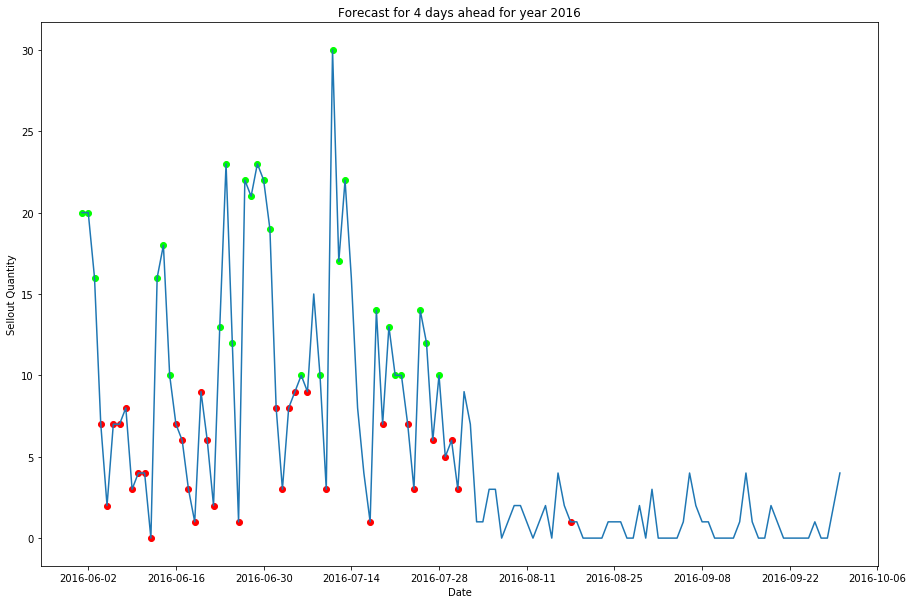

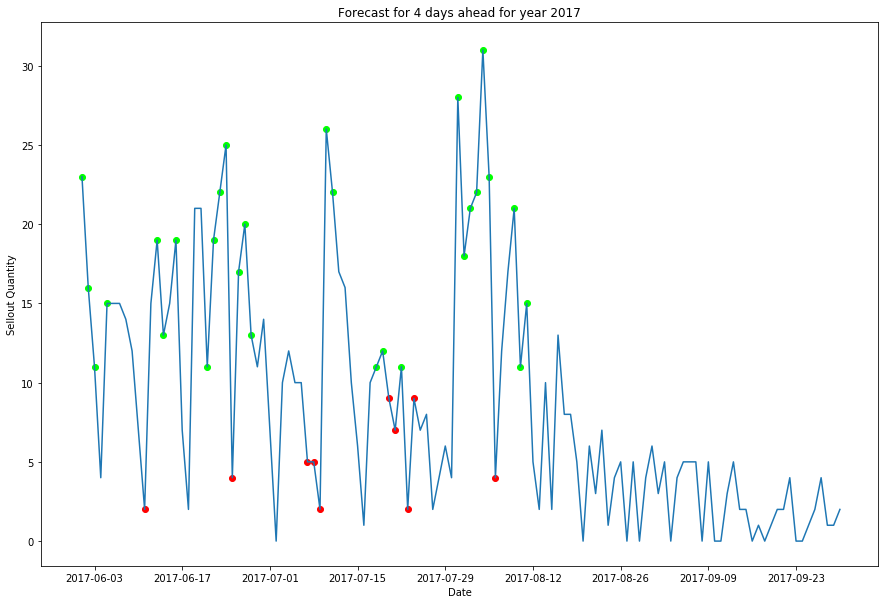

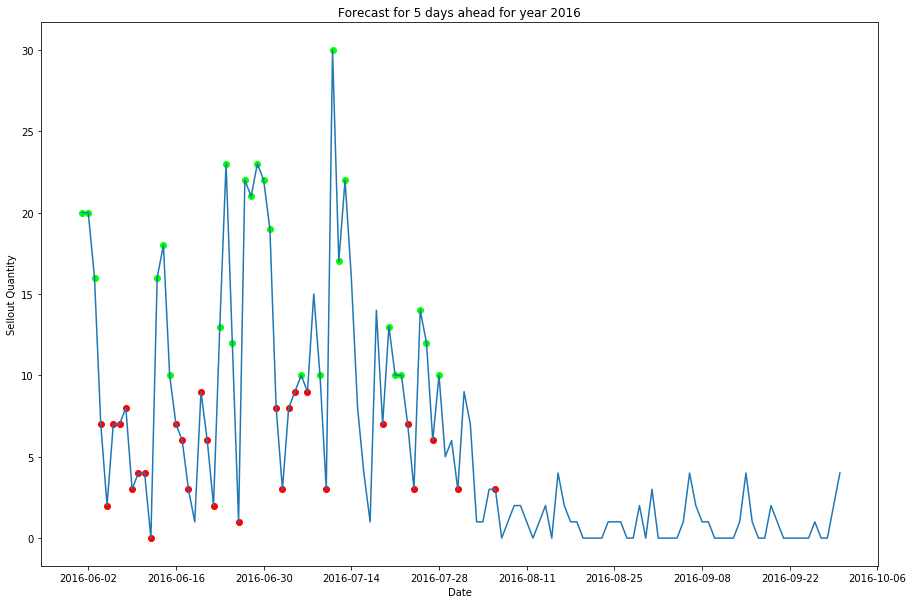

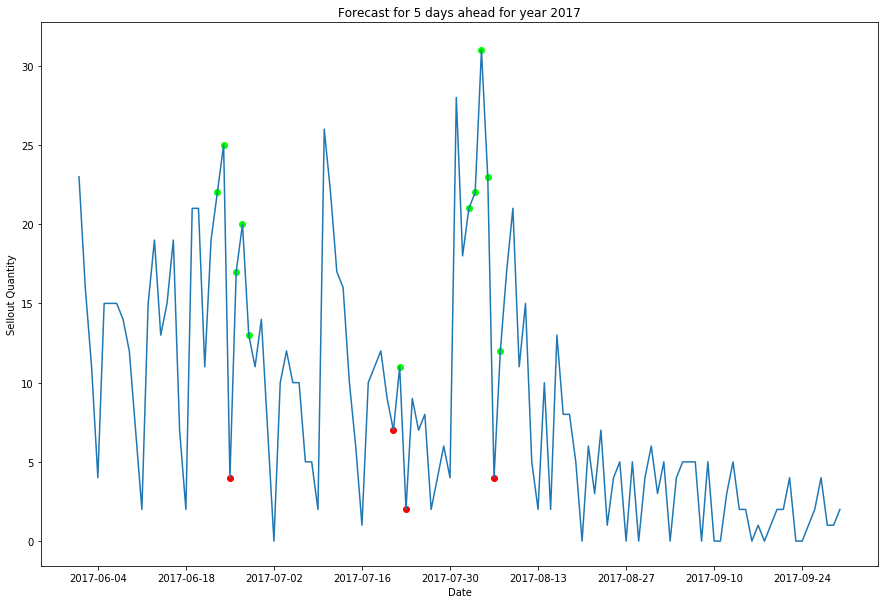

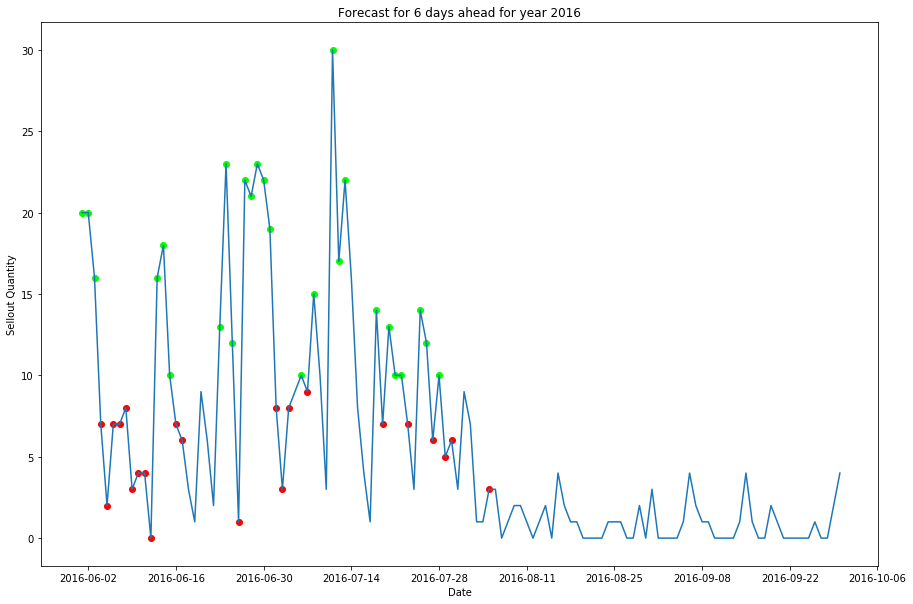

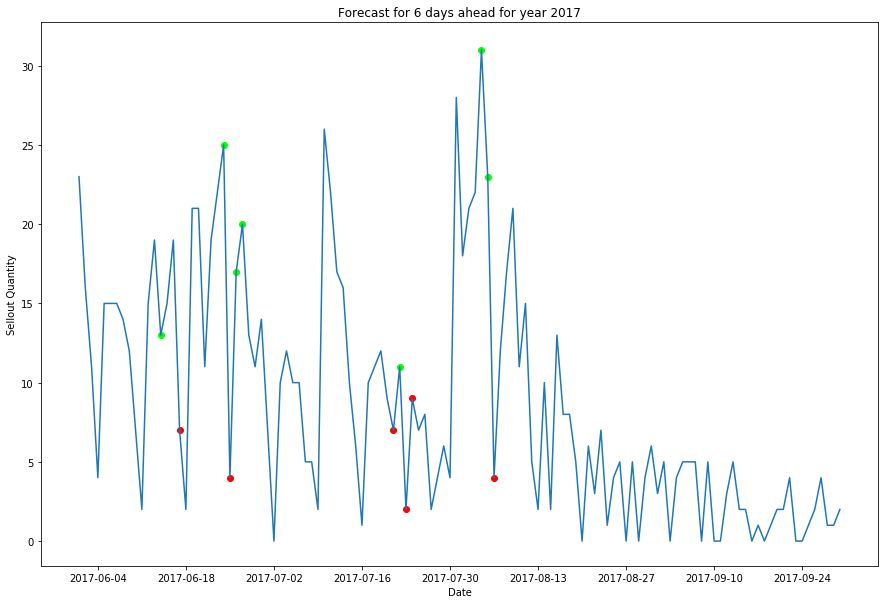

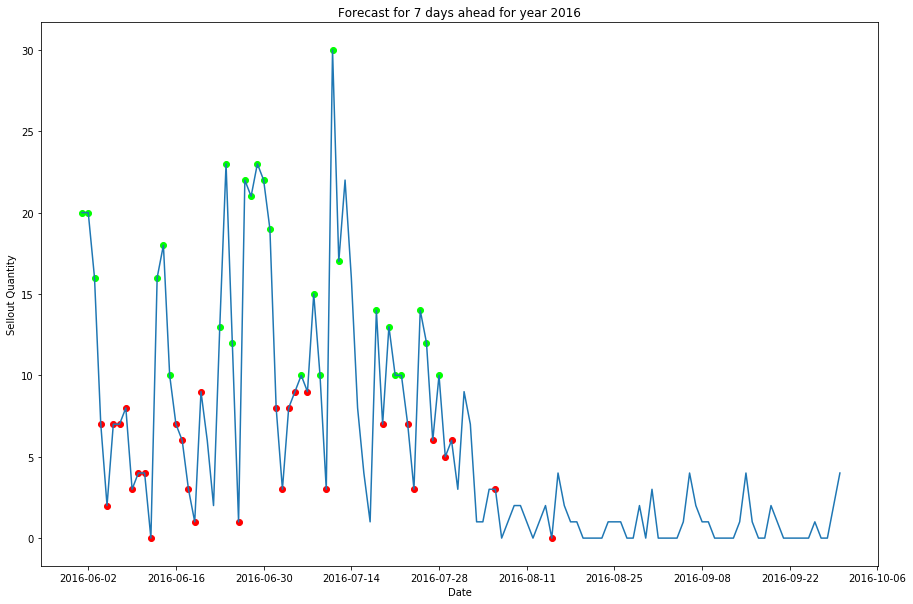

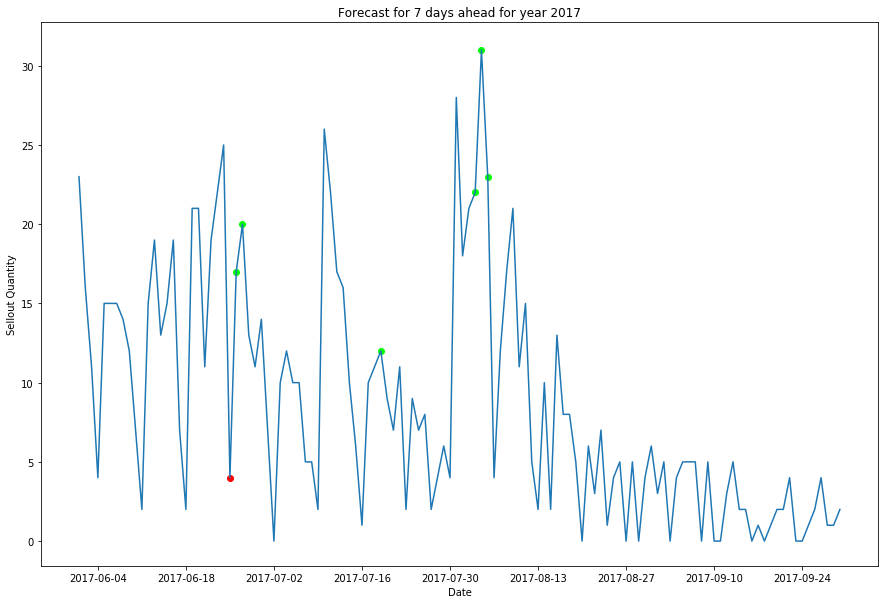

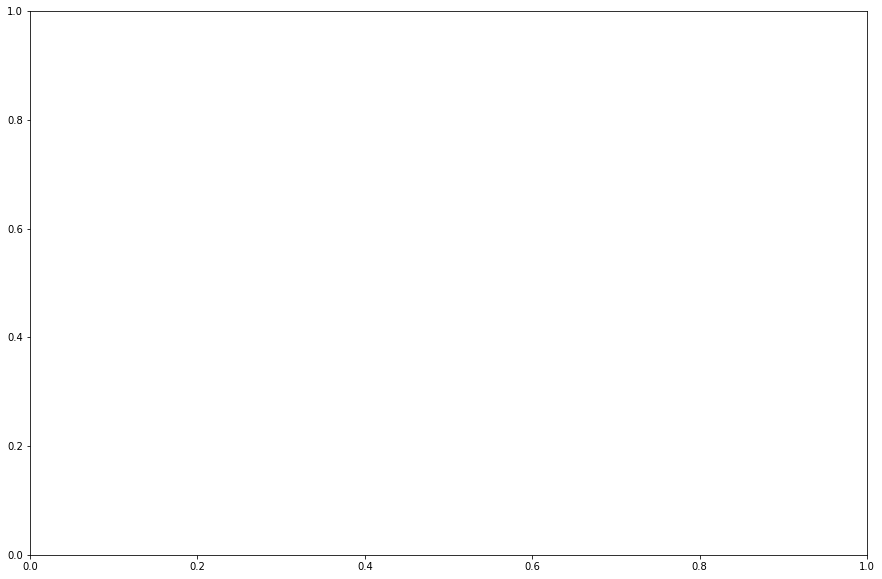

In [10]:
# use only seasonal data
mask = (ac_sellout.index.month >= 6) & (ac_sellout.index.month <= 9)

# train the model - lower bound for recall is 0.3
wa.predict_with_model(wf, ac_sellout[mask], mask=mask, recall_lim=0.3)